## Step 1: Import Required Libraries

In [129]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns


## Step 2: Model Initialization and Tokenizer Setup

In this section, we initialize a pre-trained BERT model for sequence classification, along with its tokenizer, and move the model to the available device (GPU or CPU).

### Code Breakdown:
- **PRE_TRAINED_MODEL_NAME**:  
   We specify the pre-trained model name as `'bert-base-uncased'`, which refers to the base version of BERT with uncased text (meaning the model does not differentiate between uppercase and lowercase characters).

- **Tokenizer Initialization**:  
   We use the `BertTokenizer` class from Hugging Face to load the pre-trained tokenizer. This tokenizer will convert input text into token ids, which the model can process:
   ```python
   tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [130]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


c:\Users\xrist\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step 3: Custom Dataset Class for Sentiment Analysis and DataLoader Function

This section defines the `SentimentDataset` class, which is a custom dataset to handle reviews and their associated aspects for sentiment classification. The dataset is designed to be compatible with PyTorch’s DataLoader.

### Code Breakdown:
- **`__init__(self, reviews, aspects, labels, tokenizer, max_len)`**:
  - The constructor initializes the dataset with reviews, aspects, labels, a tokenizer, and a maximum token length (`max_len`).
  - **Parameters**:
    - `reviews`: A list of review texts.
    - `aspects`: A list of aspects associated with each review (e.g., "Service", "Food").
    - `labels`: Sentiment labels associated with each review, typically as integers (e.g., 0 for negative, 1 for neutral, 2 for positive).
    - `tokenizer`: The tokenizer that converts text into input token IDs (from the BERT model).
    - `max_len`: The maximum length of tokenized sequences, important for ensuring consistency in input size to the model.

- **`__len__(self)`**:
  - Returns the total number of samples in the dataset, making it compatible with PyTorch's DataLoader.
  
- **`__getitem__(self, index)`**:
  - Retrieves a single data sample (review, aspect, label) from the dataset based on the given `index`.
  - **Steps**:
    1. **Review and Aspect Retrieval**: Fetches the review and aspect at the specified index, and converts them to strings.
    2. **Label Retrieval**: Fetches the corresponding label.
    3. **Input Text Construction**: Combines the aspect and review into a single string, formatted as:  
       `"Aspect: {aspect}. Review: {review}"`.
    4. **Tokenization**: The combined text is tokenized using the BERT tokenizer. Important settings include:
       - `max_length`: Ensures the sequence is no longer than the maximum length specified.
       - `padding='max_length'`: Pads the sequence to the maximum length.
       - `truncation=True`: Truncates sequences that are too long.
       - `return_attention_mask=True`: Returns the attention mask to indicate which tokens are padding.
       - `return_tensors='pt'`: Returns the tensors in PyTorch format.
    5. **Return Values**: The method returns a dictionary containing:
       - `'input_ids'`: Token IDs of the combined text.
       - `'attention_mask'`: Attention mask for padding.
       - `'labels'`: Sentiment label as a tensor.
       - `'aspect'`: The original aspect text for reference.
       - `'review'`: The original review text for reference.

### Why We Did This:
- **Custom Dataset Class**: Using a custom dataset class allows for easy integration with PyTorch's DataLoader, enabling efficient batching, shuffling, and parallel loading of data during training.
- **Aspect-Review Combination**: By combining the aspect with the review in the input text, the model can focus on specific aspects of the review, which is especially useful in sentiment analysis where different aspects of a product/service might receive different sentiments.
- **Tokenization**: Ensuring that the text is tokenized consistently with padding and truncation ensures that all inputs are of the same length, which is crucial when feeding data into a BERT-based model.


In [131]:
class SentimentDataset(Dataset):
    def __init__(self, reviews, aspects, labels, tokenizer, max_len):
        self.reviews = reviews
        self.aspects = aspects
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = str(self.reviews[index])
        aspect = str(self.aspects[index])
        label = self.labels[index]

        input_text = f"Aspect: {aspect}. Review: {review}"

        encoding = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
            'aspect': aspect,  # Include aspect
            'review': review  # Include review
        }


In [132]:
def create_data_loader(reviews, aspects, labels, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(reviews, aspects, labels, tokenizer, max_len)
    return DataLoader(dataset, batch_size=batch_size, num_workers=0)

## Step 4: Aspect-Based Data Loading and Preprocessing

In this section, we load and preprocess the restaurant review dataset, focusing on specific aspects (e.g., "food", "service", "ambience"). We then create PyTorch `DataLoader` objects to facilitate aspect-based sentiment analysis for both training and testing datasets.

### List of Aspects for Analysis
- We define a list of aspects that we are interested in analyzing (e.g., "food", "service", "ambience"):
  ```python
  aspects = ["food", "service", "ambience"]


In [133]:
aspects = ["food", "service", "ambience"]

def load_and_preprocess_data_train(file_path, aspects):

    data = pd.read_csv(file_path)

    data.rename(columns={'Sentence': 'review', 'Aspect Term': 'aspect_term', 'polarity': 'sentiment_labels'}, inplace=True)

    data = data[data['sentiment_labels'].isin(['positive', 'neutral', 'negative'])]
    data['sentiment_labels'] = data['sentiment_labels'].map({'positive': 2, 'neutral': 1, 'negative': 0})
    
    data = data[data['aspect_term'].isin(aspects)]
    
    return data

def load_and_preprocess_data_test(file_path, aspects):

    data = pd.read_csv(file_path)

    data.rename(columns={'Sentence': 'review', 'Aspect Term': 'aspect_term', 'polarity': 'sentiment_labels'}, inplace=True)
    
    data = data[data['sentiment_labels'].isin(['positive', 'neutral', 'negative'])]
    data['sentiment_labels'] = data['sentiment_labels'].map({'positive': 2, 'neutral': 1, 'negative': 0})

    data = data[data['aspect_term'].isin(aspects)]
    
    return data


train_data = load_and_preprocess_data_train(r"C:\Users\xrist\Downloads\Restaurants_Train_v2.csv", aspects)

train_reviews = train_data['review'].tolist()
train_aspects = train_data['aspect_term'].tolist()
train_labels = train_data['sentiment_labels'].tolist()

test_data = load_and_preprocess_data_test(r"C:\Users\xrist\Downloads\Restaurants_Test_Data_PhaseA.csv", aspects)

test_reviews = test_data['review'].tolist()
test_aspects = test_data['aspect_term'].tolist()
test_labels = test_data['sentiment_labels'].tolist()


MAX_LEN = 128
BATCH_SIZE = 8
train_data_loader = create_data_loader(train_reviews, train_aspects, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_data_loader(test_reviews, test_aspects, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)


## Step 5: Training Loop for BERT Model

This section defines a `train` function that handles the training process for a BERT model, iterating over the dataset for a specified number of epochs. The function calculates the loss, performs backpropagation, and updates the model weights accordingly.

### Code Breakdown:
- **`train(model, data_loader, optimizer, device, epochs)`**:
  - **Parameters**:
    - `model`: The BERT model for sequence classification.
    - `data_loader`: The DataLoader containing training data in batches.
    - `optimizer`: The optimization algorithm (e.g., AdamW) used to adjust the model’s weights based on the computed gradients.
    - `device`: The device (CPU or GPU) where computations will be performed.
    - `epochs`: The number of epochs (complete passes through the training dataset).

### Function Logic:

1. **Model in Training Mode**:
   - The `model.train()` call puts the model in training mode, enabling certain features like dropout and gradient updates that are only used during training.
   ```python
   model.train()


In [134]:
def train(model, data_loader, optimizer, device, epochs):
    model.train()
    training_loss_per_epoch = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        progress_bar = tqdm(data_loader, desc=f"Training Epoch {epoch + 1}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(data_loader)
        training_loss_per_epoch.append(avg_loss)
        print(f"Average training loss for epoch {epoch + 1}: {avg_loss}")


## Step 6: Hyperparameters and Training Setup

In this section, we define the key hyperparameters for training the model, set up the optimizer, and call the `train` function to start the model training process.

### Code Breakdown:

### 1. **Hyperparameters**
- **EPOCHS = 3**: 
  - The number of complete passes through the training dataset. Typically, a higher number of epochs leads to better learning, but it also increases the risk of overfitting.
  - We set it to `3` as a reasonable balance between sufficient training time and overfitting.
  
- **LEARNING_RATE = 2e-5**: 
  - The learning rate controls how large a step the optimizer takes when updating the model's weights during training.
  - A learning rate of `2e-5` (0.00002) is commonly used with BERT models as it balances making progress without overshooting optimal weights.

```python
EPOCHS = 3
LEARNING_RATE = 2e-5


In [135]:
# Hyperparameters
EPOCHS = 3
LEARNING_RATE = 2e-5

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

train(model, train_data_loader, optimizer, device, EPOCHS)

c:\Users\xrist\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


Training Epoch 1: 100%|██████████| 83/83 [00:38<00:00,  2.16it/s, loss=1.27] 


Average training loss for epoch 1: 0.8532149034989885
Epoch 2/3


Training Epoch 2: 100%|██████████| 83/83 [00:37<00:00,  2.22it/s, loss=0.951] 


Average training loss for epoch 2: 0.5942141889897455
Epoch 3/3


Training Epoch 3: 100%|██████████| 83/83 [00:39<00:00,  2.12it/s, loss=0.447] 

Average training loss for epoch 3: 0.4380270454987704


## Step 7: Model Evaluation Function

The `evaluate` function is used to assess the performance of the trained model on the test dataset. It computes metrics such as accuracy, precision, recall, and F1-score. Additionally, it inspects misclassified examples, displaying up to 10 incorrect predictions for further analysis.

### Code Breakdown:

### 1. **Function Definition: `evaluate(model, data_loader, device)`**
- **Parameters**:
  - `model`: The trained BERT model to evaluate.
  - `data_loader`: The DataLoader containing the test data in batches.
  - `device`: The computing device (CPU or GPU) on which evaluation is performed.

```python
def evaluate(model, data_loader, device):


In [136]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions, true_labels, aspects_list, reviews_list = [], [], [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            aspects = batch['aspect'] 
            reviews = batch['review']  

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            # Store all necessary information for later inspection
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            aspects_list.extend(aspects)
            reviews_list.extend(reviews)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    incorrect_predictions = [
        (aspect, review, true, pred) for aspect, review, true, pred in zip(aspects_list, reviews_list, true_labels, predictions) if true != pred
    ]

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    print("\nIncorrect Predictions (Aspect, Review, True Label, Predicted Label):")
    for aspect, review, true, pred in incorrect_predictions[:10]: 
        print(f"Aspect: {aspect}, Review: {review}")
        print(f"True Label: {true}, Predicted Label: {pred}\n")

    return accuracy, precision, recall, f1_score, aspects_list, reviews_list, true_labels, predictions


In [137]:
accuracy, precision, recall, f1_score, aspects_list, reviews_list, true_labels, predictions = evaluate(model, test_data_loader, device)

results_df = pd.DataFrame({
    'Aspect': aspects_list,
    'Review': reviews_list,
    'True Label': true_labels,
    'Predicted Label': predictions
})

print(results_df.head())

results_df.to_csv('evaluation_results.csv', index=False)


Accuracy: 0.8233
Precision: 0.8254
Recall: 0.8233
F1 Score: 0.8101

Incorrect Predictions (Aspect, Review, True Label, Predicted Label):
Aspect: service, Review: The staff isn't the friendliest or most competent, and I am stickler for service, but everything else about this place makes up for it.
True Label: 0, Predicted Label: 1

Aspect: service, Review: The service is ok but could be better.
True Label: 0, Predicted Label: 2

Aspect: food, Review: Over time, the food quality has decreased substantially, it is a lot less crowded than it used to, and the service must definitely be part of the reason.
True Label: 0, Predicted Label: 1

Aspect: service, Review: Over time, the food quality has decreased substantially, it is a lot less crowded than it used to, and the service must definitely be part of the reason.
True Label: 0, Predicted Label: 1

Aspect: ambience, Review: The staff has been nice, but they seemed really stressed and the unisex bathroom needs to be cleaned more often.
True

## Step 8: Visualizing Confusion Matrices for Aspect-Based Sentiment Analysis

In this section, we generate and display confusion matrices for the model's predictions on different aspects (e.g., food, service, and ambience). A confusion matrix provides a detailed breakdown of correct and incorrect classifications for each sentiment class.

### Code Breakdown:

### 1. **Required Imports**
- **confusion_matrix**: Computes the confusion matrix, which compares predicted labels with true labels.
- **ConfusionMatrixDisplay**: A utility from `sklearn` to display confusion matrices as plots.

```python
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


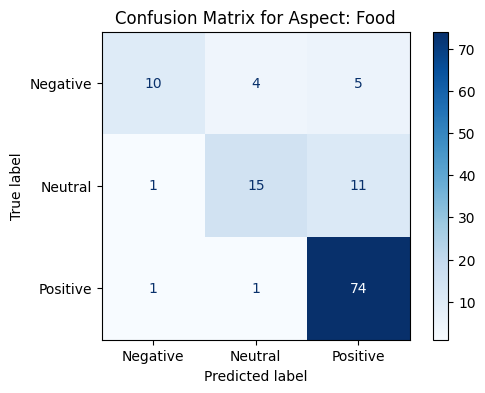

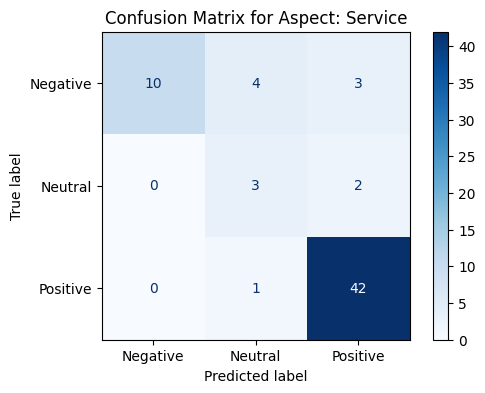

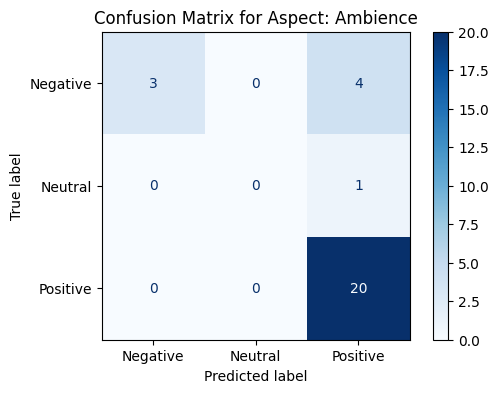

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

aspects_to_plot = ["food", "service", "ambience"]

for aspect in aspects_to_plot:

    aspect_true_labels = [true_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == aspect]
    aspect_predictions = [predictions[i] for i in range(len(aspects_list)) if aspects_list[i] == aspect]
    
    conf_matrix = confusion_matrix(aspect_true_labels, aspect_predictions, labels=[0, 1, 2])
    
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Neutral', 'Positive'])
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'Confusion Matrix for Aspect: {aspect.capitalize()}')
    plt.show()


## Visualizing the Distribution of Sentiment Labels per Aspect

In this section, we visualize the distribution of sentiment labels for different aspects in the training dataset. This analysis helps in understanding how sentiment is distributed across various aspects, which can be valuable for refining the model and ensuring balanced training.

### Code Breakdown:

### 1. **Plotting Setup**
- We set up a figure with a specified size using `plt.figure()`. The dimensions are chosen to ensure clarity and visibility of the data.



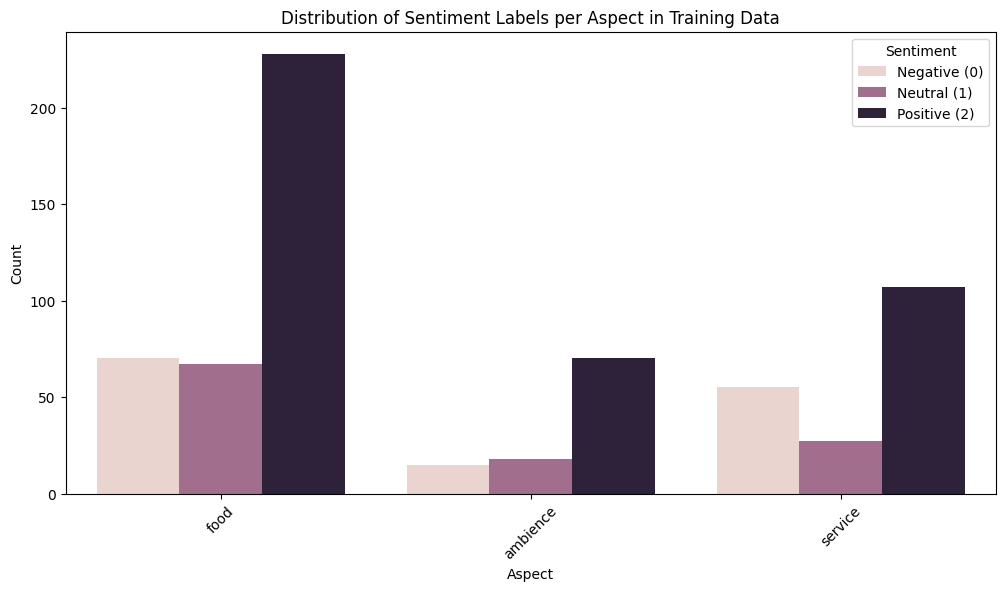

In [140]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='aspect_term', hue='sentiment_labels')
plt.title('Distribution of Sentiment Labels per Aspect in Training Data')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', labels=['Negative (0)', 'Neutral (1)', 'Positive (2)'])
plt.show()


## Predicting Sentiment for a Given Review and Aspect

In this section, we define a function that predicts the sentiment of a review based on its associated aspect using a pre-trained BERT model. This function encapsulates the steps required to prepare the input, make predictions, and map the output to human-readable sentiment labels.

### Function Definition:

```python
def predict_sentiment(aspect, review, model, tokenizer, max_len=128):


In [141]:
def predict_sentiment(aspect, review, model, tokenizer, max_len=128):

    input_text = f"Aspect: {aspect}. Review: {review}"
    
    encoding = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'  
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predicted_label = torch.argmax(logits, dim=1).cpu().item()
    
    label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = label_mapping[predicted_label]
    
    return sentiment


In [142]:
# Example
aspect = "food"
review = "The food was meh."
predicted_sentiment = predict_sentiment(aspect, review, model, tokenizer)
print(f"Predicted Sentiment for '{aspect}' aspect: {predicted_sentiment}")


Predicted Sentiment for 'food' aspect: Positive


## BONUS: Hyperparameter Tuning

Note: We manually ran the Hyperparameter tuning in a different notebook and took the best results. However when moving to the final, "cleaned up" version we had to run the tuning again, but due to the time it took, we decided to leave it unrun in this final vesion. 

You can run it yorselves to check that the code is working. 

Also the steps we took and which hyperpamaters we finally used can be seen in detail in the report itself.

In [ ]:
def train_and_evaluate_model(learning_rate, batch_size, model, tokenizer, train_data_loader, test_data_loader, epochs=3):
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Train the model
    train(model, train_data_loader, optimizer, device, epochs)
    
    # Evaluate the model
    accuracy, precision, recall, f1_score, _, _, _, _ = evaluate(model, test_data_loader, device)
    
    return f1_score

In [ ]:
import random

# Define hyperparameter space
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [8, 16, 32]

# Number of random combinations to try
n_random_trials = 10


results = []

#----------------------------------------------------------------------------------------

for _ in range(n_random_trials):
    # Sample a random learning rate and batch size
    learning_rate = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    
    print(f"Training with Learning Rate: {learning_rate}, Batch Size: {batch_size}")
    
    # Create DataLoaders with the current batch size
    train_data_loader = create_data_loader(train_reviews, train_aspects, train_labels, tokenizer, MAX_LEN, batch_size)
    test_data_loader = create_data_loader(test_reviews, test_aspects, test_labels, tokenizer, MAX_LEN, batch_size)
    
    # Clone the model for each combination to avoid issues with weights
    model_clone = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3).to(device)
    
    # Train and evaluate the model
    f1_score = train_and_evaluate_model(learning_rate, batch_size, model_clone, tokenizer, train_data_loader, test_data_loader)
    
    # Store the results
    results.append({
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'f1_score': f1_score
    })

#----------------------------------------------------------------------------------------

# Convert results to a DataFrame for better readability
import pandas as pd

results_df = pd.DataFrame(results)

# Find the best hyperparameters based on F1 score
best_params = results_df.loc[results_df['f1_score'].idxmax()]

print("Best Hyperparameters:")
print(best_params)